# Import

In [4]:
# Libraries import
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [5]:
# Datasets import
y = scipy.io.loadmat('y_CT.mat')
y = y.get('y')
x = scipy.io.loadmat('x_CT.mat')
x = x.get('x')

# Preprocessing

In [9]:
# Remove outliers
delete=np.argwhere((y>0.3)|(y<0.08))
y = np.delete(y,delete[:,0])
x = np.delete(x,delete[:,0],axis=0)

In [13]:
Acc_range=16
Gyr_range=2000

# Scale the samples from 0 to 1
x[:,:,0:3] = x[:,:,0:3] / (Acc_range*2*9.81) + 0.5
x[:,:,3:6] = x[:,:,3:6]/ (Gyr_range*2) + 0.5

In [14]:
# Function to split a portion of data from the dataset and create a train and a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Keras sequential

In [19]:
input_shape = [41,6,1]

# Model building
model = tf.keras.models.Sequential([
          keras.Input(shape=input_shape),
          tf.keras.layers.Conv2D(32, kernel_size= (8,1), activation= 'relu', padding= 'SAME'),
          tf.keras.layers.Conv2D(64, kernel_size= (4,1), activation='relu', padding= 'SAME'),
          tf.keras.layers.MaxPooling2D(pool_size= (2,1), strides= (2,1), padding= 'SAME'),
          layers.Dropout(0.5, noise_shape=[None,1,6,64], seed= 42),
          layers.Flatten(),
          layers.Dense(256, activation= 'softmax'),
          layers.Dropout(0.1, seed= 42),
          layers.Dense(1)
                        ])

In [21]:
# Model compilation
model.compile(optimizer='nadam',
              loss=tf.keras.losses.MeanAbsoluteError(reduction= "auto", name= "mean_absolute_error")
              )

In [22]:
# Define a checkpoint for the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

# Fit the model to the train dataset
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb])

# Reload the best model
model = keras.models.load_model("best_model.h5")

Epoch 1/100
34/34 [==============================] - 3s 38ms/step - loss: 0.0529 - val_loss: 0.0198
Epoch 2/100
 5/34 [===>..........................] - ETA: 0s - loss: 0.0270

c:\Users\mercu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 1s 32ms/step - loss: 0.0248 - val_loss: 0.0199
Epoch 3/100
34/34 [==============================] - 1s 34ms/step - loss: 0.0236 - val_loss: 0.0199
Epoch 4/100
34/34 [==============================] - 1s 34ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 5/100
34/34 [==============================] - 1s 35ms/step - loss: 0.0223 - val_loss: 0.0199
Epoch 6/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0224 - val_loss: 0.0196
Epoch 7/100
34/34 [==============================] - 1s 41ms/step - loss: 0.0218 - val_loss: 0.0189
Epoch 8/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0212 - val_loss: 0.0175
Epoch 9/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0199 - val_loss: 0.0170
Epoch 10/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0189 - val_loss: 0.0157
Epoch 11/100
34/34 [==============================] - 1s 36ms/step - loss: 0.0181 - val_loss: 0.0158
Epoch 12/1

In [23]:
# Print the MAE on the validation set
print('Min val_loss: '+str(min(history.history['val_loss'])))

Min val_loss: 0.013044219464063644


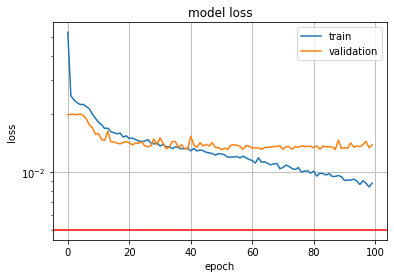

In [24]:
# Show the history of the loss parameters over each epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(y=0.005, color='r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.yscale('log')
plt.grid()
plt.show()

In [25]:
# Sort the sample according to labels ascending order
ind = np.argsort( y_test )
y_test_sorted = y_test[ind]
x_test_sorted = x_test[ind]

# Make predictions on the test set
pred=model.predict(x_test_sorted)

11/11 [==============================] - 0s 4ms/step


In [26]:
# MAE of the test set
print(np.mean(np.abs(pred[:,0]-y_test_sorted)))

0.013127831065369255


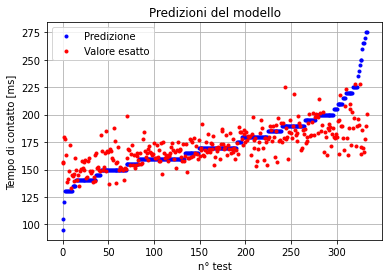

In [27]:
# Show predictions and labels
plt.plot(y_test_sorted*1000,'b.',pred*1000,'r.')
# plt.axhline(y=0, color='b')
plt.title('Predizioni del modello')
plt.ylabel('Tempo di contatto [ms]')
plt.xlabel('n° test')
plt.legend(['Predizione', 'Valore esatto'], loc='upper left')
plt.grid()

(array([ 8., 11., 24., 27., 52., 56., 36., 46., 34., 15., 15.,  2.,  2.,
         2.,  4.]),
 array([0.13358527, 0.13985898, 0.14613268, 0.1524064 , 0.1586801 ,
        0.1649538 , 0.1712275 , 0.1775012 , 0.18377492, 0.19004862,
        0.19632232, 0.20259602, 0.20886973, 0.21514344, 0.22141714,
        0.22769085], dtype=float32),
 <BarContainer object of 15 artists>)

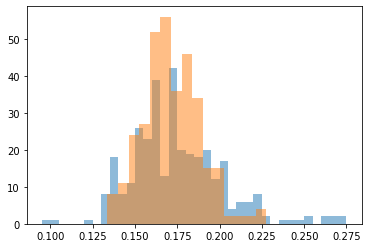

In [28]:
# Show histogram of predictions and labels
bins=((max(y_test_sorted)-min(y_test_sorted))/0.005)
plt.hist(y_test_sorted,int(bins),alpha=0.5)
plt.hist(pred,int(bins/2.3),alpha=0.5)

In [29]:
# output mat file
import scipy.io as sio
outdict={"y_test":y_test_sorted,"y_pred":pred}
sio.savemat('y_predCT.mat', outdict)